In [1]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache
import pandas as pd
import corner

np.random.seed(1234)

In [2]:
#path_to_data = '/home/ubuntu/atmosphere'
path_to_data = '/home/ubuntu'
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(f"{path_to_data}/atmosphere/xsecs")
CIACache().set_cia_path(f"{path_to_data}/atmosphere/cia/hitran")

# Creating transmission spectrum 

We define the system's parameters in order to build the spectrum, together with the desired chemical abundancies.

In [3]:
from taurex.temperature import Isothermal
isothermal = Isothermal(T=1415.0)

from taurex.planet import Planet
planet = Planet(planet_radius=1.2,planet_mass=0.58)

from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6230.0,radius=1.28)

from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

from taurex.chemistry import ConstantGas
H2O = 1e-04
CH4 = 1e-04
CO2 = 1e-04
CO = 1e-04

chemistry.addGas(ConstantGas('H2O',mix_ratio=H2O))
chemistry.addGas(ConstantGas('CH4',mix_ratio=CH4))
chemistry.addGas(ConstantGas('CO2',mix_ratio=CO2))
chemistry.addGas(ConstantGas('CO',mix_ratio=CO))

Numba not installed, using numpy instead


In [4]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()
res = tm.model()

from taurex.binning import FluxBinner,SimpleBinner

We import the spectrum of point A and refer to it as the observed one:

In [5]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum(f'WASP_62b_synthetic_spectrum.dat')

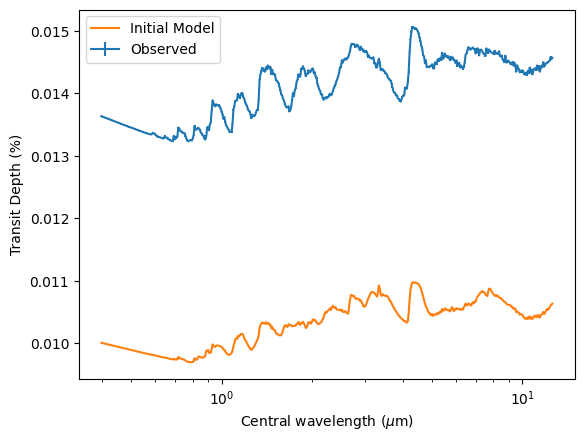

In [6]:
obin = obs.create_binner()
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum, obs.errorBar,label='Observed')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='Initial Model')
plt.xscale('log') 
plt.xlabel(r'Central wavelength ($\mu$m)')
plt.ylabel('Transit Depth (%)')
plt.legend()
plt.show()

# Atmospheric retrival 

We now perform an atmospheric retrieval of the synthetic spectrum of point A. We retrieve the molecular abundances for all the molecules, together with the temperature and the radius of the planet.

In [7]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=50)

opt.set_model(tm)
opt.set_observed(obs)

In [8]:
opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.enable_fit('H2O')
opt.enable_fit('CH4')
opt.enable_fit('CO2')
opt.enable_fit('CO')
opt.set_boundary('T',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.1])
opt.set_boundary('H2O', [1e-10,1e-2])
opt.set_boundary('CH4', [1e-10,1e-2])
opt.set_boundary('CO', [1e-10,1e-2])
opt.set_boundary('CO2', [1e-10,1e-2])

In [9]:
solution = opt.fit()
taurex.log.disableLogging()

it=    35 logz=-151510043.3907251

it=  1764 logz=5258.115404504601niter: 1765
ncall: 8547
nsamples: 1815
logz: 5258.339 +/-  0.796
h: 31.707


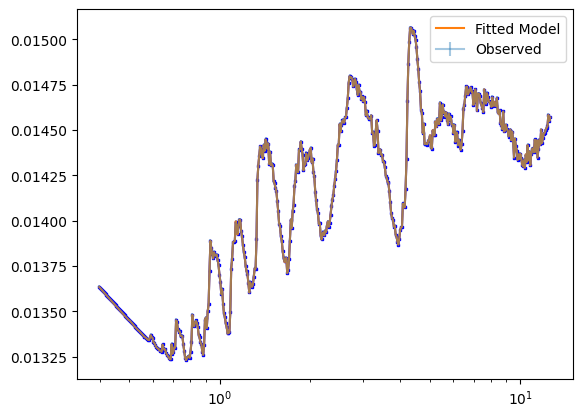

In [10]:

for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Observed', alpha=0.4)
    plt.plot(obs.wavelengthGrid,obs.spectrum, color='blue', marker='s', markersize=2)
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='Fitted Model')
    plt.xscale('log')
    plt.legend()
    plt.show()

In [11]:
res = opt.generate_solution()
fit_params = res['solution0']['fit_params']
traces = np.array([fit_params[key]['trace'] for key in fit_params.keys()])

# we save the traces array to a .npy file for convenience 
np.save('traces_WASP-62b.npy', traces)

In [12]:
path = '/home/ubuntu/comp_astro_24/assignment3/traces_WASP-62b.npy'
traces = np.load(path)

In [13]:
params = [[key,fit_params[key]['value'], fit_params[key]['sigma_m'], fit_params[key]['sigma_p']] for key in fit_params.keys()]
df = pd.DataFrame(params, columns=['param','value', 'sigma_m', 'sigma_p'], index=None)
df.to_csv('WASP-62b-fit.csv', header=True, index=False, sep='\t')

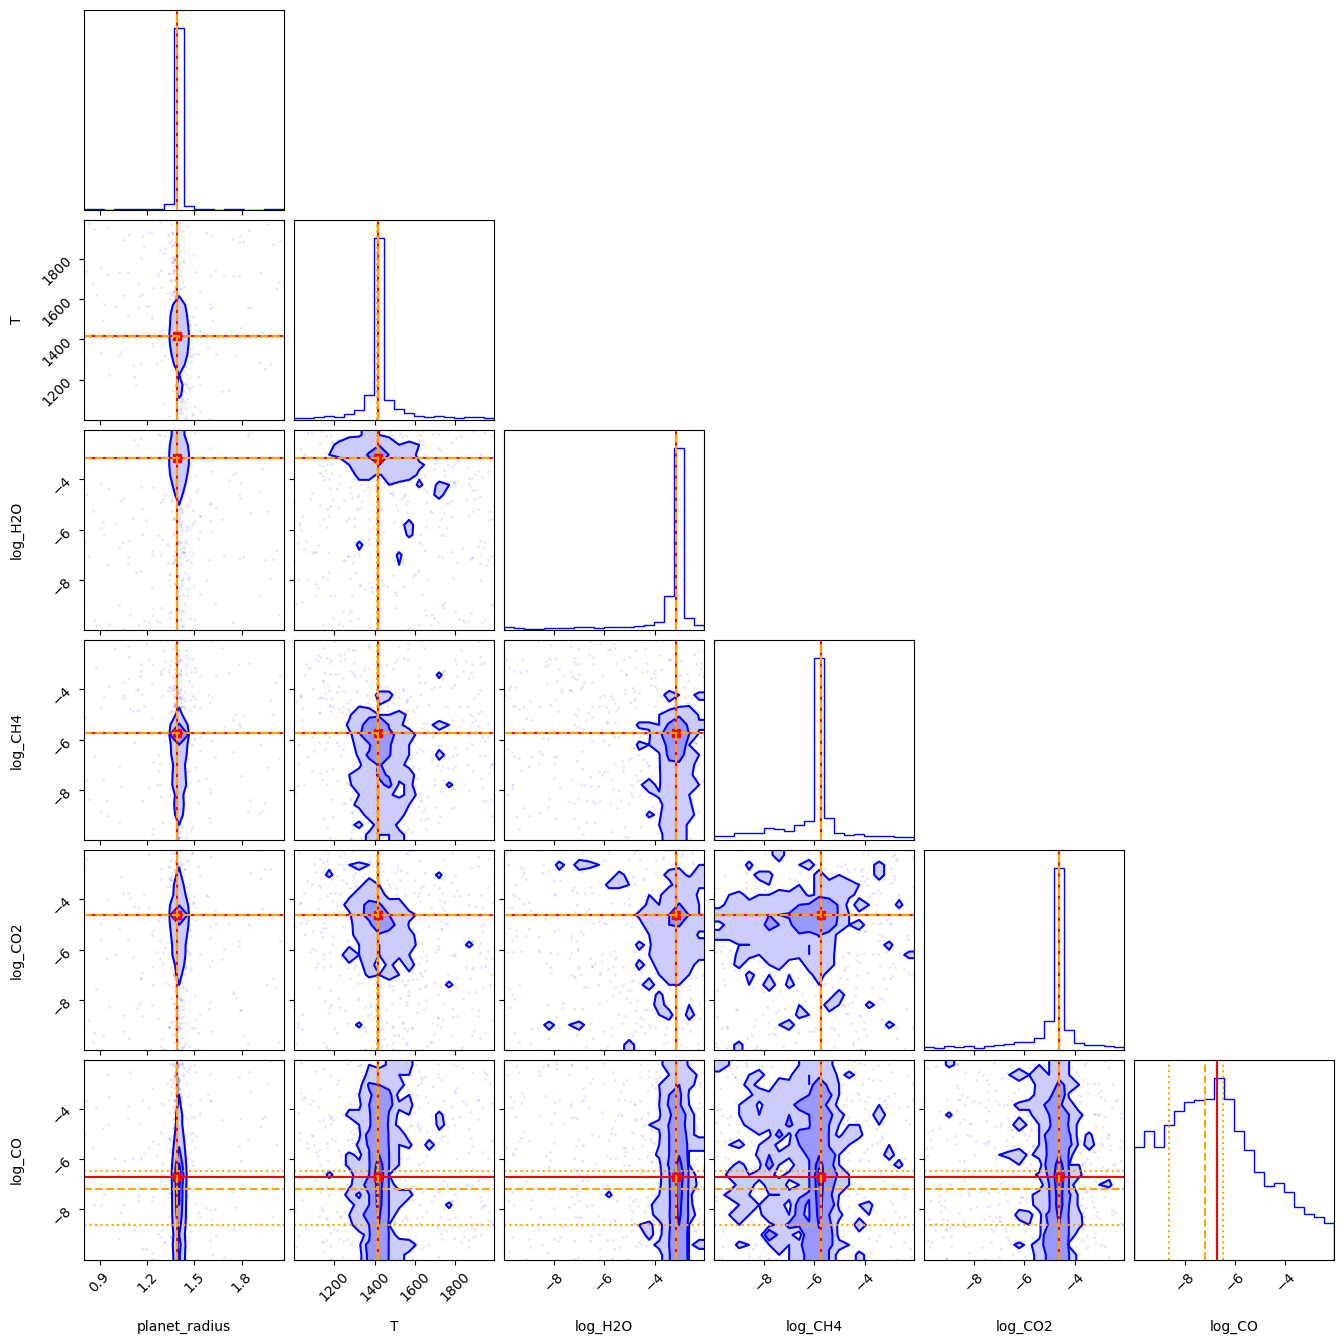

In [15]:
params = pd.read_csv('WASP-62b-fit.csv', sep='\t')['param']
true_values =  [ 1.39, 1415.0, -3.1491167022733535, -5.732652626238991,-4.626366434042687,-6.712151502282615 ]

# Create the corner plot with colors and labels
fig = corner.corner(
    np.transpose(traces),  
    labels=params, 
    titles=params, 
    color='blue',  
    plot_datapoints=True,  
    fill_contours=True,
    truths = true_values,
    truth_color = 'red'
)

corner.overplot_lines(fig, df['value'], linestyle='dashed', c='orange')
corner.overplot_lines(fig, df['value']+df['sigma_p'], linestyle='dotted', c='orange')
corner.overplot_lines(fig, df['value']-df['sigma_m'], linestyle='dotted', c='orange')
plt.savefig('WASP_62b_cornerplot.png')
plt.show()